### ResNet-LSTM
- ResNet-50 (standard)
- LSTM

This is the original ResNet-LSTM model.

Best Model (Val Acc)
- Epoch 11 (fine-tune): loss: 2.5802 - accuracy: 0.5117 - val_loss: 1.5738 - val_accuracy: 0.5774

Best Model (Val Loss)
- Epoch 6: loss: 0.6423 - accuracy: 0.7372 - val_loss: 0.9317 - val_accuracy: 0.5245


In [0]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/train_frames.tar.gz' .

In [0]:
!tar -xzf train_frames.tar.gz

In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/val_frames.tar.gz' .
!tar -xzf val_frames.tar.gz

In [0]:
!ls 'drive/My Drive/cs231n-project/datasets/emotiw/'

 AutomaticGroupLevelAffectandCohesion.pdf   Train.zip
'Copy of Train.zip'			    unzip.ipynb
'Copy of Val.zip'			    val
 models					    val_frames.tar.gz
 train					    Val_labels.txt
 train_frames.tar.gz			    Val.zip
 Train_labels.txt			    VGAF_readme.txt


In [0]:
!nvidia-smi

Fri May 22 05:26:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import random
import cv2
from os import listdir
from os.path import isfile, join

class DataGenerator(tf.keras.utils.Sequence):
    """
    Generates data based on a directory of frames
    """
    def __init__(self, dir, batch_size=32, frames_to_use=-1, shuffle=True):
        self.frames_to_use = frames_to_use
        self.batch_size = batch_size
        self.dir = dir
        self.shuffle = shuffle
        self.classes = self.find_classes()
        self.video_names, self.video_map, self.video_to_class, self.num_samples, self.min_frames = self.find_samples()
        self.on_epoch_end()
        print(f"Found {self.num_samples} frames belonging to {len(self.video_names)} videos belonging to {len(self.classes)} classes.")
        print(f"Min frames determined to be {self.min_frames}")

    def find_classes(self):
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        return sorted(list(set(category_folders)))

    def find_samples(self):
        """
        Returns the following video frame structure:

        {
            "vid1": [
                "frame1.jpg",
                "frame2.jpg",
                ...
            ]
        }

        """
        num_samples = 0
        min_frames = -1
        video_map = {}
        vid_to_cat = {}
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        for category_folder in category_folders:
            cat_path = join(self.dir, category_folder)
            frames = [f for f in listdir(cat_path) if isfile(join(cat_path, f))]
            for frame in frames:
                # frame = frame_101_7.mp4_8.jpg
                frame_arr = frame.split(".mp4_")
                vid_name = frame_arr[0]
                if vid_name not in video_map:
                    video_map[vid_name] = []
                    vid_to_cat[vid_name] = category_folder
                video_map[vid_name].append(frame)
            
            for k in video_map.keys():
                # make sure the frames for each video are in sorted order
                video_map[vid_name] = sorted(video_map[vid_name])
                if min_frames == -1 or len(video_map[vid_name]) < min_frames:
                    min_frames = len(video_map[vid_name])

        return list(video_map.keys()), video_map, vid_to_cat, len(vid_to_cat), min_frames

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        video_names = self.video_names[index*self.batch_size:(index+1)*self.batch_size]

        # print(f"Working on batch {index} with {len(video_names)} videos")

        num_frames = self.min_frames if self.frames_to_use == -1 else self.frames_to_use
        X = np.zeros((len(video_names), num_frames, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
        y = []
        i = 0
        for vid in video_names:
            # print(vid)
            j = 0
            for frame in self.video_map[vid]:
                # print("   " + frame)
                frame_path = join(join(self.dir, self.video_to_class[vid]), frame)
                img = cv2.imread(frame_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Assume resized already
                # img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
                # print(img[0])
                X[i, j, :, :, :] = img
                j += 1
                if j >= num_frames:
                    break

            y.append(int(self.video_to_class[vid]) - 1)
            # print(f"{vid} - {int(self.video_to_class[vid]) - 1}")
            i += 1
        y = np.array(y)
        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

    def on_epoch_end(self):
        # print("on_epoch_end")
        if self.shuffle == True:
            np.random.shuffle(self.video_names)




In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
FRAMES = 12
BATCH_SIZE = 32
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-lstm"

In [0]:
train_generator = DataGenerator("train_frames", frames_to_use=FRAMES, batch_size=BATCH_SIZE)
validation_generator = DataGenerator("val_frames", frames_to_use=FRAMES, batch_size=BATCH_SIZE)

X, y = train_generator.__getitem__(0)


Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 13
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 13


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


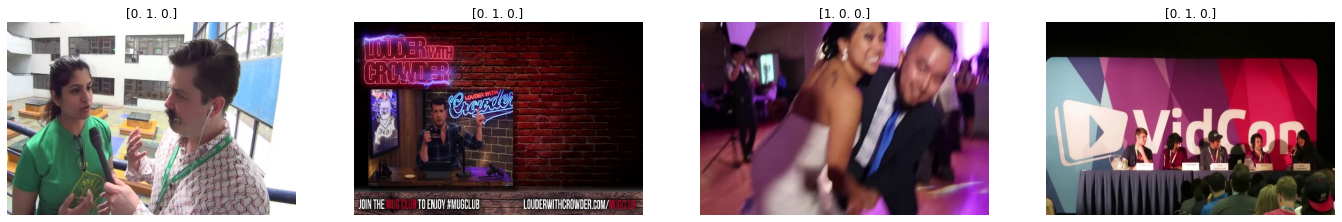

In [0]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(30,30))
    for n in range(4):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(image_batch[n, 0])
          plt.title(label_batch[n])
          plt.axis('off')
image_batch, label_batch = train_generator.__getitem__(1)
show_batch(image_batch, label_batch)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


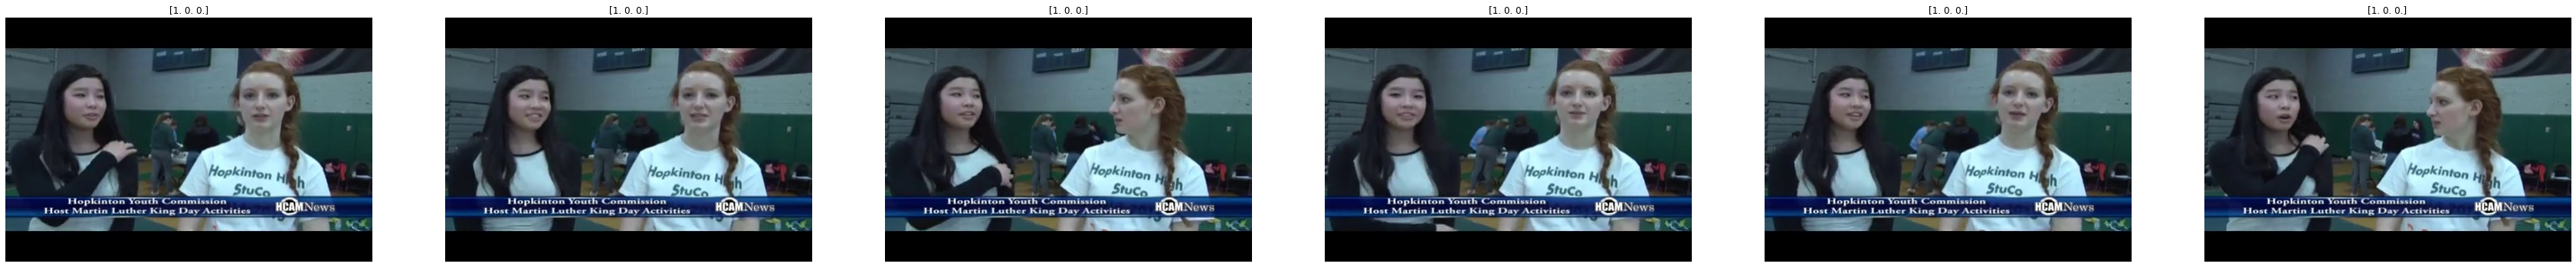

In [0]:
def show_frames_batch(image_batch, label_batch):
    plt.figure(figsize=(60,60))
    for n in range(6):
        ax = plt.subplot(1,6,n+1)
        plt.imshow(image_batch[0, n])
        plt.title(label_batch[0])
        plt.axis('off')
image_batch, label_batch = train_generator.__getitem__(0)
show_frames_batch(image_batch, label_batch)

In [0]:
!pip install keras-self-attention


  Created wheel for keras-self-attention: filename=keras_self_attention-0.42.0-cp36-none-any.whl size=17296 sha256=86efa0e1a04af296ca3386667fbc8e2ed6a182231ab43f70a65aa2cf5b319ef1
  Stored in directory: /root/.cache/pip/wheels/7b/05/a0/99c0cf60d383f0494e10eca2b238ea98faca9a1fe03cac2894
Successfully built keras-self-attention


In [0]:
from pathlib import Path
import keras
from keras_self_attention import SeqSelfAttention

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    period=1)

def create_model(inputs):
    base_model = get_base_model(BASE_NAME)
    base_model.trainable = False
    # for layer in base_model.layers[:NUM_TOP_LAYERS_TO_RETRAIN]:
    #     layer.trainable = False
    # for layer in base_model.layers[NUM_TOP_LAYERS_TO_RETRAIN:]:
    #     layer.trainable = True

    x = tf.keras.layers.TimeDistributed(base_model)(inputs)
    x = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def create_cnnlstm_model(inputs):
    x = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def create_selfattn_model(inputs):
    x = keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(inputs)
    x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.TimeDistributed(SeqSelfAttention(attention_activation='sigmoid'))(inputs)
    model = keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def create_resnetwithresidual_model(inputs):
    base_model = get_base_model(BASE_NAME)
    for layer in base_model.layers[:NUM_TOP_LAYERS_TO_RETRAIN]:
        layer.trainable = False
    for layer in base_model.layers[NUM_TOP_LAYERS_TO_RETRAIN:]:
        layer.trainable = True

    x1 = tf.keras.layers.TimeDistributed(base_model)(inputs)
    x1 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)
    x1 = tf.keras.layers.Dense(512)(x1)

    x2 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(inputs)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.GlobalAveragePooling3D()(x2)
    x2 = tf.keras.layers.Dense(512)(x2)

    x = tf.keras.layers.Add()([x1, x2])
    x = tf.keras.layers.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
# model = create_cnnlstm_model(inputs)
# model = create_resnetwithresidual_model(inputs)

# Notes: 
# - Use keras import
# - Square image
# inputs = keras.Input(shape=(FRAMES, 3, IMG_HEIGHT, IMG_HEIGHT))
# model = create_selfattn_model(inputs)

model.summary()




Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 12, 320, 480, 3)] 0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 12, 10, 15, 2048)  23587712  
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, 12, 10, 15, 40)    3006880   
_________________________________________________________________
global_average_pooling3d_7 ( (None, 40)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 123       
Total params: 26,594,715
Trainable params: 3,007,003
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
initial_epochs = 10

# Try evaluating the model for a few rounds
# history = model.fit(train_generator, epochs=1)
loss0, accuracy0 = model.evaluate(validation_generator, steps = 3)

3/3 [==============================] - 3s 1s/step - loss: 1.1452 - accuracy: 0.3542


In [0]:
validation_generator.batch_size

32

In [0]:
import pickle
history = model.fit(
          train_generator,
          epochs=initial_epochs,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

Epoch 1/10
83/83 [==============================] - ETA: 0s - loss: 0.9628 - accuracy: 0.5456
Epoch 00001: saving model to drive/My Drive/checkpoints/resnet-lstm/cp-0001.ckpt
83/83 [==============================] - 188s 2s/step - loss: 0.9628 - accuracy: 0.5456 - val_loss: 0.9991 - val_accuracy: 0.5340
Epoch 2/10
83/83 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.6299
Epoch 00002: saving model to drive/My Drive/checkpoints/resnet-lstm/cp-0002.ckpt
83/83 [==============================] - 185s 2s/step - loss: 0.8514 - accuracy: 0.6299 - val_loss: 0.9442 - val_accuracy: 0.5584
Epoch 3/10
83/83 [==============================] - ETA: 0s - loss: 0.7879 - accuracy: 0.6562
Epoch 00003: saving model to drive/My Drive/checkpoints/resnet-lstm/cp-0003.ckpt
83/83 [==============================] - 185s 2s/step - loss: 0.7879 - accuracy: 0.6562 - val_loss: 1.0702 - val_accuracy: 0.4728
Epoch 4/10
83/83 [==============================] - ETA: 0s - loss: 0.7455 - accuracy

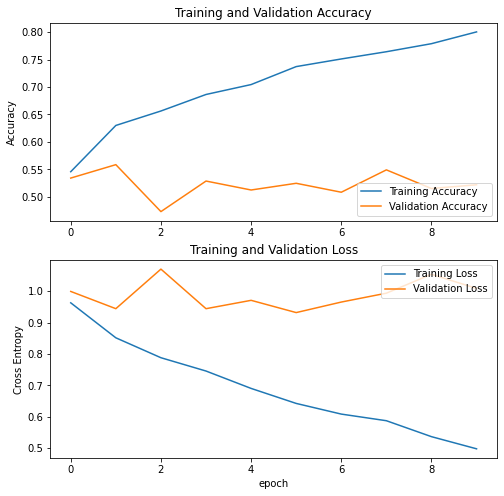

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

model.save(f"drive/My Drive/checkpoints/{MODEL_NAME}/m1.h5")


Due to overfitting, let's try adding regularization

In [0]:

def create_model(inputs):
    base_model = get_base_model(BASE_NAME)
    base_model.trainable = False

    x = tf.keras.layers.TimeDistributed(base_model)(inputs)
    x = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01), recurrent_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model


inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()



Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 12, 320, 480, 3)] 0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 12, 10, 15, 2048)  23587712  
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, 12, 10, 15, 40)    3006880   
_________________________________________________________________
global_average_pooling3d_8 ( (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 123       
Total params: 26,594,715
Trainable params: 3,007,003
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
import pickle
history = model.fit(
          train_generator,
          epochs=initial_epochs,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history-v2.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

Epoch 1/10
83/83 [==============================] - ETA: 0s - loss: 2.5802 - accuracy: 0.5117
Epoch 00001: saving model to drive/My Drive/checkpoints/resnet-lstm/cp-0001.ckpt
83/83 [==============================] - 202s 2s/step - loss: 2.5802 - accuracy: 0.5117 - val_loss: 1.5738 - val_accuracy: 0.5774
Epoch 2/10
83/83 [==============================] - ETA: 0s - loss: 1.4687 - accuracy: 0.5934
Epoch 00002: saving model to drive/My Drive/checkpoints/resnet-lstm/cp-0002.ckpt
83/83 [==============================] - 187s 2s/step - loss: 1.4687 - accuracy: 0.5934 - val_loss: 1.4210 - val_accuracy: 0.5462
Epoch 3/10
83/83 [==============================] - ETA: 0s - loss: 1.3330 - accuracy: 0.6020
Epoch 00003: saving model to drive/My Drive/checkpoints/resnet-lstm/cp-0003.ckpt
83/83 [==============================] - 187s 2s/step - loss: 1.3330 - accuracy: 0.6020 - val_loss: 1.5073 - val_accuracy: 0.4783
Epoch 4/10
83/83 [==============================] - ETA: 0s - loss: 1.2773 - accuracy

In [0]:
!pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=a7d1a840394c6bae9713afdb30b4fbe5a3b4d1130bd37667ee38307c839292af
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-resnet


In [0]:
import keras
import keras_resnet.models
model = keras_resnet.models.TimeDistributedResNet50(inputs, classes=validation_generator.classes)
model.compile("adam", "categorical_crossentropy", ["accuracy"])
# model.fit(training_x, training_y)
loss0, accuracy0 = model.evaluate(validation_generator, steps = 5)

AttributeError: ignored